# Example 1 : vacancy

This section shows the IFC embedding procedure on a vacancy. The example system is the F-center in CaO, i.e. the oxygen vacancy ($V_O$) in CaO, as shown in the image below. The isosurface represents the in-gap "1s" defect state. 

![](../images/V_O_CaO.png)

Computations details :
- CaO (2 atoms/cell)
- Pristine phonons are computed with dfpt (abinit) on a 4x4x4 q-mesh
- The 4x4x4 pristine phonons are folded on the correspondind 4x4x4 supercell (128 atoms)
- Defect phonons are computed with phonopy + abinit on a 2x2x2 supercell with one O vacancy (15 atoms)

## Create the pristine phonopy object

We start by opening a DDB file of CaO computed on a 4x4x4 q-mesh.

We then go from a 4x4x4 q-mesh to a 4x4x4 supercell (folding procedure) with abipy/dfpt/converters/ddb_ucell_to_phonopy_supercell

One could first interpolate on a denser q-mesh with (then folded on a larger supercell, see commented code)

In [1]:
from abipy.embedding.embedding_ifc import Embedded_phonons
from abipy.abilab import abiopen
from abipy.core.kpoints import kmesh_from_mpdivs
from abipy.dfpt.converters import ddb_ucell_to_phonopy_supercell,ddb_ucell_to_ddb_supercell
import phonopy
from pymatgen.io.phonopy import get_pmg_structure,get_phonopy_structure
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings
#from abipy import abilab
#abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline


In [2]:
help(ddb_ucell_to_phonopy_supercell)

Help on function ddb_ucell_to_phonopy_supercell in module abipy.dfpt.converters:

ddb_ucell_to_phonopy_supercell(unit_ddb=None, unit_ddb_filepath=None, nac=True) -> 'Phonopy'
    Convert a DDB file or DDB instance of a unit cell on a q-mesh to the corresponding supercell
    at q=Gamma.
    
    Args:
        ddb_unit_cell: an instance of DDB file.
        unit_ddb_filepath : alternatively, a path to the input DDB.
        supercell_ddb_path: DDB path of the output DDB on a supercell at Gamma
        nac : Set the non-analytical correction
    
    Returns:
        a Phonopy instance.



In [3]:
# open a 4x4x4 q-mesh ddb of CaO
ddb_pristine_444 = abiopen("../files/example_1/bulk_out_DDB")

#qpts=kmesh_from_mpdivs(mpdivs=[6,6,6],shifts=[0,0,0],order="unit_cell")
#ddb_pristine_666=ddb_pristine.anaget_interpolated_ddb(qpt_list=qpts)

# go from a 4x4x4 q-mesh to a 4x4x4 supercell

ph_pristine=ddb_ucell_to_phonopy_supercell(unit_ddb=ddb_pristine_444,nac=False)

## Create the defect phonopy object

We open a DDB file of CaO with $V_O$. This DDB file was computed on a 2x2x2 supercell. 

We then convert this DDB file to phonopy format.

In [4]:
ddb_defect= abiopen("../files/example_1/defect_out_DDB")

ph_defect=ddb_defect.anaget_phonopy_ifc()

## Create the embedded phonopy object

In order to construct an embedded phonopy object, use `abipy/embedding.embedding_ifc/Embedded_phonons`.

The parameters are shown in the cell below. 

One critical aspect is to provide the correct structural informations to the code. In order to perform the matching, the code expects the defect structure (15 atoms supercell) without defect-induced relaxation.

The code also expects the coordinate of the defect in the large pristine supercell. 

See the code below for a detailed example.

In [5]:
help(Embedded_phonons.from_phonopy_instances)


Help on method from_phonopy_instances in module abipy.embedding.embedding_ifc:

from_phonopy_instances(phonopy_pristine, phonopy_defect, structure_defect_wo_relax, main_defect_coords_in_pristine, main_defect_coords_in_defect, substitutions_list: list = None, vacancies_list: list = None, interstitial_list: list = None, tol_mapping=0.01, cut_off_mode='auto', rc_1=None, rc_2=None, factor_ifc=1, verbose=0, asr=True) -> phonopy.api_phonopy.Phonopy class method of abipy.embedding.embedding_ifc.Embedded_phonons
    Args:
        phonopy_pristine: Phonopy object of the pristine structure
        phonopy_defect  : Phonopy object of the defect structure
        structure_defect_wo_relax : Supercell structure associated to the defect structure, but without relaxation. Needed for an easier mapping.
            Should corresponds to order of phonopy_defect structure!
        main_defect_coords_in_pristine : Main coordinates of the defect in pristine structure, if defect complex, can be set to the
 

In [6]:
########

# index of the O vacancy = 8 (in 15 atoms defect structure), this is found manually
idefect_defect_stru=8

# We need first to create the defect structure without relax
ddb_pristine_structure=ddb_pristine_444.structure
structure_defect_wo_relax=ddb_pristine_structure.copy()
structure_defect_wo_relax.make_supercell(2)

main_defect_coords_in_defect=structure_defect_wo_relax.cart_coords[idefect_defect_stru]

structure_defect_wo_relax.remove_sites(indices=[idefect_defect_stru])
structure_defect_wo_relax.sort() # important. 



# index of the vacancy = 64 (in pristine structure), this is either found manually or with the help code get_index_in_pristine_stru

idefect_pristine_stru=64
main_defect_coords_in_pristine=get_pmg_structure(ph_pristine.supercell).cart_coords[idefect_pristine_stru]

def get_index_in_pristine_stru(coords_defect_stru_defect,pristine_stru,tol=0.1):
    pristine_stru_cart=pristine_stru.cart_coords
    for j, site_2 in enumerate(pristine_stru):  
        if max(abs(coords_defect_stru_defect - pristine_stru_cart[j])) < tol :
            index=j
    return index

print(get_index_in_pristine_stru(main_defect_coords_in_defect,get_pmg_structure(ph_pristine.supercell)))


64


In [7]:
ph_emb=Embedded_phonons.from_phonopy_instances(
                               phonopy_pristine=ph_pristine,
                               phonopy_defect=ph_defect,
                               structure_defect_wo_relax=structure_defect_wo_relax,
                               main_defect_coords_in_pristine=main_defect_coords_in_pristine,
                               main_defect_coords_in_defect=main_defect_coords_in_defect, 
                               substitutions_list=None, 
                               vacancies_list=[idefect_pristine_stru],       
                               interstitial_list=None,  
                               cut_off_mode='auto',
                               factor_ifc=1,
                               verbose=0,
                               asr=True,)

### The phonopy object can be converted to a DDB

#ddb=ph_emb.to_ddb(tmp_dir+"out_DDB")


Number of atoms in the pristine supercell      : 128
Number of atoms in the defective supercell     : 15
Defect infos
    Vacancies :
       64, [1.97007526 1.39305357 3.41227044], O1 removed
Mapping after structure manipulation           : 15/15

 Set IFC to explicit defect phonons calculations if both atoms are separated from defect by a distance < R_c2 = 3.378

 Enforce ASR



 Embedding procedure done


## Phonons modes and localisation ratio
We finally obtain the phonon eigenvectors and eigenfrequencies of the embedded system with 
`abipy/embedding/utils_ifc/get_gamma_freq_with_vec_abipy_fmt()` (such that eigenfrequencies are in eV and that ph_vec[iband][iatom] gives eigenvector of iband,iatom)

The localization ratio of each mode and the most localized modes can be visualized with vesta thanks to `abipy/embedding/utils_ifc/vesta_phonon()`

In [8]:
freqs,vecs=ph_emb.get_gamma_freq_with_vec_abipy_fmt()

In [9]:
# Extract the localization ratio of each phonon mode and print the 3 most localized modes

from abipy.embedding.utils_ifc import localization_ratio

ratio=localization_ratio(vecs)

ibands=np.argsort(ratio)[::-1][:3]

print("band indices:",ibands )
print("localization ratio:", ratio[ibands])
print("frequencies :", freqs[ibands])



band indices: [123 100 209]
localization ratio: [12.58568782 10.30587315  9.61470298]
frequencies : [0.02748962 0.02655018 0.03389308]


In [10]:
# Prepare the structure for vesta_phonons 

from abipy.core.structure import Structure

Structure(species=get_pmg_structure(ph_emb.supercell).species,
          coords=get_pmg_structure(ph_emb.supercell).frac_coords,
          lattice=get_pmg_structure(ph_emb.supercell).lattice).visualize()

# visualize the structure with vesta
# Save it in vesta format. TO COMPLETE

Writing data to: .xsf with fmt: xsf
Executing MacOSx open command: open -a vesta --args   /Users/jbouquiaux/git/lumi_book/lumi_book/ifc_emb/examples/.xsf


0

## Unfolding

We finally draw the phonon band structure of the embedded system onto the wave vector path of the underlying unit cell (unfolding procedure). We use the phonopy implementation, see https://iopscience.iop.org/article/10.1088/1361-648X/acd831/meta.

In [11]:
# Obtain the q-path
bs,dos=ddb_pristine_444.anaget_phbst_and_phdos_files(ndivsm=10,nqsmall=2,dipdip=1)
qpoints=bs.phbands.qpoints.frac_coords


In [12]:
#### P. B. Allen et al., Phys. Rev. B 87, 085322 (2013)
#### Implemented in Phonopy

from phonopy.unfolding.core import Unfolding

unfolding_supercell_matrix = np.diag([4,4,4]) # supercell size

mapping = list(np.arange(len(ph_pristine.supercell)))
mapping[idefect_pristine_stru]=None # set the vacancy, see 
# https://github.com/phonopy/phonopy/blob/7f34627cf0ef68f688f744c2f51f44856d47e27e/phonopy/unfolding/core.py

unfolding_emb = Unfolding(ph_emb, unfolding_supercell_matrix,
                             ph_pristine.supercell.scaled_positions, mapping, qpoints)


In [13]:
unfolding_emb.run()

In [14]:
# prepare the plotting

x=unfolding_emb.qpoints
y=unfolding_emb.frequencies
z=unfolding_emb.unfolding_weights

nqpts=len(x)
nfreq=len(y[0])
xs=np.arange(len(x))


new_xs=[]
new_z=[]
new_y=[]

# keep only weights > 1e-5 for vizualisation.

for i,q in enumerate(xs):
    new_z_per_q=[]
    new_y_per_q=[]
    for j,weight in enumerate(z[i]):
        if z[i,j] > 1e-5:
            new_z_per_q.append(z[i,j])
            new_y_per_q.append(y[i,j])
    new_z.append(np.array(new_z_per_q))
    new_y.append(np.array(new_y_per_q))
    

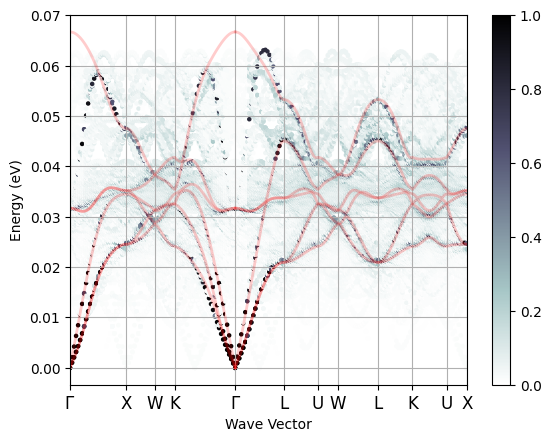

In [15]:
fig,axs=plt.subplots()


for i,q in enumerate(x):
    sc=axs.scatter([xs[i]]*len(new_y[i]),0.00413566*new_y[i], marker='.', # put in eV
                   s=20,vmin=0, vmax=1 ,c=(new_z[i])**(1/2), cmap='bone_r',alpha=1)

cbar = plt.colorbar(sc)

bs.phbands.plot(ax=axs,alpha=0.2,color='r');



